<a href="https://colab.research.google.com/github/Tinkolik/MNIST_NN/blob/master/MNIST_VER_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Модули

In [1]:
import numpy  as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import keras
import tensorflow as tf
from keras.datasets import mnist

In [3]:
import matplotlib.pyplot as plt

## Датасет MNIST

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

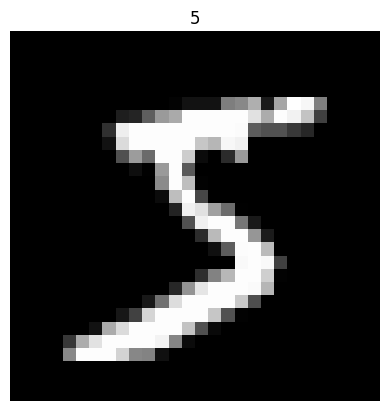

In [5]:
ind = y_train[0] # 0
img = X_train[0] # shape = (1, 28, 28) # <class 'torch.Tensor'>
# img = np.squeeze(img) # или: img = img.reshape(28, 28)
img = img.reshape(28, 28)
plt.imshow(img, cmap = plt.get_cmap('gray'))
# Если не употреблять transform = ToTensor():
# img = test_data[0][0] # shape = (28, 28) # <class 'PIL.Image.Image'>
# plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.title(ind)
plt.axis('off')
plt.show()

In [6]:

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
y_train = y_train[:, np.newaxis].T
y_test = y_test[:, np.newaxis].T

x = X_train
xo = np.ndarray((len(x),28**2))
for i in range(len(x)):
  xo[i] = x[i].flatten()
X_train = xo.T

x = X_test
xo = np.ndarray((len(x),28**2))
for i in range(len(x)):
  xo[i] = x[i].flatten()
X_test = xo.T

In [7]:
# Преобразовываем числа из датасета в массив из 10 элементов, где в индексе числа стоит единица
def encode(Y):
  result = []
  for i in Y[0]:
    temp = np.zeros(10)
    temp[i] = 1
    result.append(temp)
  return np.array(result).T

In [8]:
# Обратная трансформация для вывода
def decode(Y):
  y = Y.T
  out = []
  for yi in y:
    out.append(np.argmax(yi))
  return np.array(out).T

In [9]:
y_train = encode(y_train)
y_test = encode(y_test)

print(y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


## Модель

In [10]:
class dlnet:
    def __init__(self, x, y):
        self.X=x  # входные данные
        self.Y=y  # размеченные данные, target
        self.Yh=np.zeros((1,self.Y.shape[1]))  # реальный выход перцептрона
        self.L=2  # количество слоев
        self.dims = [28*28, 20, 10]  # 28**2 фичей на вход, 20 нейронов в скрытом слое,
                                # 10 нейронов на выходе
        self.param = {}  # параметры и базисы для каждого слоя
        self.ch = {}  # кэш для вякого
        self.grad = {}  #
        self.loss = []  # для хранения значений лоссов
        self.lr=0.003
        self.sam = self.Y.shape[1]  # количество тренировачных образцов

    def nInit(self):
        """
        Инициализирует начальные параметры для сети
        """
        np.random.seed(1)

        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0])
        self.param['b1'] = np.zeros((self.dims[1], 1))
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1])
        self.param['b2'] = np.zeros((self.dims[2], 1))
        return

    def Sigmoid(self, Z):
        return 1/(1+np.exp(-Z))

    def Relu(self, Z):
        return np.maximum(0,Z)

    def forward(self):
        # первый слой
        Z1 = self.param['W1'].dot(self.X) + self.param['b1']
        # функция активации
        A1 = self.Relu(Z1)
        # сохраняем в кэш результаты
        self.ch['Z1'],self.ch['A1']=Z1,A1
        # второй слой
        Z2 = self.param['W2'].dot(A1) + self.param['b2']
        # функция активации
        A2 = self.Sigmoid(Z2)
        # сохраняем в кэш результаты
        self.ch['Z2'],self.ch['A2']=Z2,A2
        # выход сети
        self.Yh=A2
        # считаем лоссы
        loss=self.nloss(A2)
        #print(self.param)
        #print(self.Yh)
        return self.Yh, loss

    def nloss(self,Yh):
        # кросс-энтропия
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))
        return loss

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def dSigmoid(self, Z):
        s = 1/(1+np.exp(-Z))
        dZ = s * (1-s)
        return dZ

    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))

        dLoss_Z2 = dLoss_Yh * self.dSigmoid(self.ch['Z2'])
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1]))
        #dLoss_W2 = np.dot(dLoss_Z2,self.ch['A1'].T)
        #dLoss_b2 = np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1]))

        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_Z1 = dLoss_A1 * self.dRelu(self.ch['Z1'])
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))
        #dLoss_W1 = np.dot(dLoss_Z1,self.X.T)
        #dLoss_b1 = np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))

        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2

    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)

        self.nInit()

        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()

            if i % 50 == 0:
                print ("Cost after iteration %i: %f" %(i, loss.sum()))
                self.loss.append(loss)

        return

    def pred(self,x, y):
        self.X=x
        self.Y=y
        comp = np.zeros((10,x.shape[1]))
        pred, loss= self.forward()
        acc = 0
        comp = comp.T
        for i in range(pred.shape[1]):
          #print(np.argmax(pred.T[i]))
          comp[i][np.argmax(pred.T[i])] = 1
          acc = acc + np.dot(comp[i,:], y[:,i])
        comp = comp.T
        print("Проверка данных:")
        print("предсказанное число моделью: " + str(np.argmax(pred.T[0])))
        print("Трансформированное число: " + str(comp.T[0]))

        print("Точность модели: " + str(acc/x.shape[1]*100) + '%')
        return comp

    def check(self, num, y, c):
      print("Истинные метки: " + str(y.T[num]))
      print("Предсказ метки: " + str(c.T[num]))

## Обучение

In [11]:
nn = dlnet(X_train, y_train)
nn.lr=0.2
nn.dims = [28**2, 24, 10]
nn.gd(X_train, y_train, iter = 201)

Cost after iteration 0: 69.102286
Cost after iteration 50: 37.699210
Cost after iteration 100: 50.345764
Cost after iteration 150: 59.723858
Cost after iteration 200: 66.647554


## Проверка

In [12]:
c = nn.pred(X_test, y_test)
#print(X_train.shape[1])

Проверка данных:
предсказанное число моделью: 7
Трансформированное число: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Точность модели: 88.01%


In [13]:
for i in range(0, 10):
  print(c.T[i])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [19]:
nn.check(0, y_test, c)

Истинные метки: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Предсказ метки: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [20]:
print("y_test shape: " + str(y_test.shape))

y_test shape: (10, 10000)


In [21]:
print("Кол-во правильных предсказанных меток: " + str((c==y_test).sum()))

Кол-во правильных предсказанных меток: 97602


In [22]:
cn = decode(c)
yn = decode(y_test)
print("Точность: " + str((cn==yn).sum()/100) + '%')

Точность: 88.01%
